# Execution of SoS workflows

The content of this chapter is largely applicable to batch mode but we represent it in Jupyter notebook for easy reproduction of results. If you are not familiar with Jupyter notebook, please refer to chapter [Notebook Interface](../documentation/Notebook_Interface.html) for details. For the impatience, the magics

* `%sandgox` execute the cell in a temporary directory
* `!cmd` execute shell command `cmd`
* `%run` run the cell as if in command line with specified options
* `%rerun` rerun the last executed script (cell content without magics)
* `%set` set options that would be included in each `$run` command

## logging level

SoS uses a logging system to output all sorts of information during the execution of workflows. The amount of output can be controlled by logging level, which can be `error` (0), `warning` (1), `info` (2), `debug` (3), and `trace` (4). The default logging level for SoS is `info` in batch mode and `warning` in interactive mode.

For example, logging at `info` level would produce message indicating the steps executed and input output files, but nothing but warning and errors at the `warning` level.

In [1]:
%sandbox
!touch a.txt

%run -v3
[10]
[20]
input: 'a.txt'
[30]
[40]

DEBUG: Workflow default created with 4 sections: default_10, default_20, default_30, default_40
DEBUG: Executing default_10: 
DEBUG: input:    []
DEBUG: output:   []
DEBUG: Executing default_20: 
DEBUG: input:    [file_target('a.txt')]
DEBUG: output:   []
DEBUG: Executing default_30: 
DEBUG: input:    []
DEBUG: output:   []
DEBUG: Executing default_40: 
DEBUG: input:    []
DEBUG: output:   []
DEBUG: Workflow default (ID=9ecd6f946ef5282b) is executed successfully.


In [2]:
%sandbox
!touch a.txt

%run -v1
[10]
[20]
input: 'a.txt'
[30]
[40]

## `dryrun` mode

The `dryrun` mode is used to check for syntax errors of a SoS script without actually executing any of the actions. It can be specified with option `-n`. For example, running the following script in dryrun mode would produce an error message

In [3]:
%sandbox --expect-error
%run -n
[10, skip=False]
sh:
   echo "I am command echo"

File contains parsing errors: 
	[line  2]: [10, skip=False]
sh:
   echo "I am command echo"
Invalid statements: SyntaxError('invalid syntax', ('<string>', 1, 10, '[10, skip=False]\n'))


because the header of the step is wrong (should use `:` instead of `,`).

The dryrun mode would print the commands in a script without actually executing them:

In [4]:
%run -n
[10: skip=False]
sh:
   echo "I am command echo"
   sleep 100000000

/bin/sh:
echo "I am command echo"
sleep 100000000




## Change system $PATH

There are cases where you would like to use a specific version of programs for your workflow but do not want to change the system `$PATH` because of its global effect. In this case you can prepend pathes to these executables to `$PATH` using option `-b`.

The following example first cretes a executable `ls` in `tmp` with an `echo` command. Using the option `-b tmp`, the `tmp` directory is prefixed to the system `$PATH` before the workflow is executed. The consequence is that this fake `ls` supersedes the system `ls` when `ls` is called in `step_10` of the workflow.

In [5]:
%sandbox
!mkdir tmp
!echo "#!/bin/bash" > tmp/ls
!echo "echo This is fake ls" >> tmp/ls
!chmod +x tmp/ls

%run -b tmp
[10]
sh:
    ls

This is fake ls


The `-b` option has a default value `~/.sos/bin`, so any command under `~/.sos/bin` would be executed (before system command with the same name) even if the executables are not under system `$PATH`. This feature allows you to create commands that would only be used inside SoS-scripts, and more interestingly, allows you to create executable or install programs on-the-fly.

For example, step 20 of the following workflow depends on an executable `lls` that is not a system executable.

In [6]:
%sandbox
!rm -f ~/.sos/bin/lls

[install_lls: provides=executable('lls')]
run:
    echo "#!/bin/bash" > ~/.sos/bin/lls
    echo "echo This is lls" >> ~/.sos/bin/lls
    chmod +x ~/.sos/bin/lls

[20]
depends: executable('lls')
run:
    lls

because `lls` is created under `~/.sos/bin`, it would be immediately available to SoS after the `install_lls` step. This works for any program as long as you can create a symbolic link under `~/.sos/bin` after its installation.

You can always disable this behavior by setting option `-b` without value.

## Runtime signature

One of the most annonying problems with the development and execution of workflows is that it can take very long times to execute then. What makes things worse is that we frequently need to re-run the workflow with different paremeters and even different tools -- it can be really time-consuming to re-execute the whole workflow repeatedly, but it is also very error-prone to repeat selected steps of a workflow. 

SoS addresses this problem by using <font color='red'>runtime signatures</font> to keep track of <font color='red'>execution units</font>, namely the input, output, and dependent targets, and related SoS variables of a piece of workflow. SoS tracks execution of statements at the step level for each [input group](../documentation/SoS_Step.html) and saves runtime signatures at a folder called `.sos` under the project directory. The runtime signatures are used to

1. Avoid repeated execution of identical units, and
2. Keep track of workflow related files for project management

This tutorial focuses on the first usage. The second one would be described in detail in [Project Management](Project_Management.html).

### `ignore` mode

SoS workflows can be executed in batch mode and in interactive mode using the SoS kernel in Jupyter notebook or qtconsole. Because the SoS kernel is mostly used to execute short statements in SOS and other kernels, runtime signatures are by default set to `ignore` in interactive mode (and to `default` in batch mode).

Let us create a temporary directory and execute a workflow that take a bit of time to execute. This is done in the default `ignore` signature mode of the Jupyter notebook

In [7]:
%sandbox --dir tmp

!rm -rf .sos/.runtime
![ -d temp ] || mkdir temp

In [8]:
%sandbox --dir tmp
%run
parameter: size=1000
[10]
output:  "temp/result.txt"
sh: expand=True
    dd if=/dev/urandom of={_output} count={size}

[20]
output:  'temp/size.txt'
with open(_output[0], 'w') as sz:
    sz.write(f"{_input}: {os.path.getsize(_input[0])}\n")

1000+0 records in
1000+0 records out
512000 bytes transferred in 0.041920 secs (12213687 bytes/sec)


Now, if we re-run the last script, nothing changes and it takes a bit of time to execute the script.

In [9]:
%sandbox --dir tmp
%rerun

INFO: default_10 (index=0) is ignored due to saved signature
INFO: default_20 (index=0) is ignored due to saved signature


### `default` mode

Now let us switch to `default` mode of signature by running the script with option `-s default`. When you run the script for the first time, it would execute normally and save runtime signature of the steps.

In [10]:
%sandbox --dir tmp
%rerun -s default

INFO: default_10 (index=0) is ignored due to saved signature
INFO: default_20 (index=0) is ignored due to saved signature


but both steps would be ignored. Here we use `-v2` to show the `ignored` message. This time we use magic `%set` to make option `-s default` persistent so that we do not have to specify it each time.

In [11]:
%sandbox --dir tmp
%set -s default
%rerun -v2

Set sos options to "-s default"


INFO: default_10 (index=0) is ignored due to saved signature
INFO: default_20 (index=0) is ignored due to saved signature


However, if you use a different parameter (not the default `size=1000`), the steps would be rerun

In [12]:
%sandbox --dir tmp
%rerun -v2 --size 2000

2000+0 records in
2000+0 records out
1024000 bytes transferred in 0.085565 secs (11967497 bytes/sec)


The signature is at the step level so if you change the second step of the script, the first step would still be skipped. Note that the step is independent of the script executed so a step would be skipped even if its signature was saved by the execution of another workflow. The signature is clever enough to allow minor changes such as addition of spaces and comments.

In [13]:
%sandbox --dir tmp
%run --size 2000 -v2
parameter: size=1000
[10]
output:  "temp/result.txt"
# added comment
sh: expand=True
    dd if=/dev/urandom of={_output} count={size}

[20]
output:  'temp/size.txt'
with open(_output[0], 'w') as sz:
    sz.write(f"Modified {_input}: {os.path.getsize(_input[0])}\n")

INFO: default_10 (index=0) is ignored due to saved signature


### `assert` mode

The `assert` mode is used to detect if anything has been changed after the execution of a workflow. For example,

In [14]:
%sandbox --dir tmp
%set -s assert
%rerun --size 2000 -v2

Set sos options to "-s assert"


INFO: Step default_10 (index=0) is ignored with matching signature
INFO: Step default_20 (index=0) is ignored with matching signature


Now if you change one of the output files, sos would fail with an error message.

In [15]:
%sandbox --expect-error --dir tmp
!echo "aaa" >> temp/result.txt
%rerun --size 2000 -v2

Failed to process step output: "temp/result.txt" (Signature mismatch: File has changed temp/result.txt)


### `force` mode

The `force` signature mode ignores existing signatures and re-run the workflow. This is needed when you would like to forcefully re-run all the steps to generate another set of output if outcome of some steps is random, or to re-run the workflow because of changes that is not tracked by SoS, for example after you have installed a new version of a program.

In [16]:
%sandbox --dir tmp
%set
%rerun --size 2000 -s force

Reset sos options from "-s assert" to ""
2000+0 records in
2000+0 records out
1024000 bytes transferred in 0.088850 secs (11525039 bytes/sec)


### `build` mode

The `build` mode is somewhat opposite to the `force` mode in that it creates (or overwrite existing signature if exists) with existing output files. It is useful, for example, if you are adding a step to a workflow that you have tested outside of SoS (without signature) but do not want to rerun it, or if for some reason you have lost your signature files and would like to reconstruct them from existing outputs.

In [17]:
%sandbox --dir tmp
%rerun --size 2000 -s build -v2

INFO: Step default_10 (index=0) is ignored with signature constructed
INFO: Step default_20 (index=0) is ignored with signature constructed


This mode can introduce erraneous files to the signatures because it does not check the validity of the incorporated files. For example, SoS would not complain if you change parameter and replace `temp/result.txt` with something else.

In [18]:
%sandbox --dir tmp
!echo "something else" > temp/result.txt
%rerun -s build -v2

INFO: Step default_10 (index=0) is ignored with signature constructed
INFO: Step default_20 (index=0) is ignored with signature constructed


In [19]:
# cleanup
!rm -rf tmp

### Removal of large intermediate files

SoS keep tracks of all intermediate files and will rerun steps only if any of the tracked files are removed or changed. However, it is often desired to remove some of the large non-essential intemediate files to reduce diskspace used by completed workflows, while allowing the workflow to be re-executed without these files. SoS provides a command

```
sos remove files --zap
```

to zap specified file, or for example

```
sos remove . --size +5G --zap
```
to zap all files larger than 5G. This command removes specified files but keeps a special `{file}.zapped` file with essential information (e.g. md5 signature, and size). SoS would consider a file exist when a `.zapped` file is present and will only regenerate the file if the actual file is needed for a later step.

For example, let us execute a workflow with output `temp/result.txt`, and `temp/size.txt`.

In [20]:
%run -s force
[10]
output:  "temp/result.txt"
# added comment
sh: expand=True
    dd if=/dev/urandom of={_output} count=2000

[20]
output:  'temp/size.txt'
with open(_output[0], 'w') as sz:
    sz.write(f"Modified {_input}: {os.path.getsize(_input[0])}\n")

2000+0 records in
2000+0 records out
1024000 bytes transferred in 0.082577 secs (12400549 bytes/sec)


and let us zap the intermediate file `temp/result.txt`,

In [21]:
!sos remove temp/result.txt --zap -y
!ls temp

INFO: No tracked file from 0 run are identified.
INFO: 0 file zapped
result.txt size.txt


As you can see, `temp/result.txt` is replaced with `temp/result.txt.zapped`. Now if you rerun the workflow

In [22]:
%rerun -s default -v2

INFO: default_10 (index=0) is ignored due to saved signature
INFO: default_20 (index=0) is ignored due to saved signature


## Summary Report

Command `sos run` accepts an option `-p` (rePort) for generating a summary report after the completion of the workflow. This option accepts a name for the generated output but an name containing a timestamp would be generated automatically if it is the parameter is given without value.

Using the same example but converting one of the steps as a task, a report named "test.html" would be generated with option `-p test.html`, showing summary of steps and tasks.

In [3]:
%preview -n test.html
%run -p test.html -s force
parameter: size=1000
[10]
output:  "temp/result.txt"
task:
sh: expand=True
    dd if=/dev/urandom of={_output} count={size}

[20]
output:  'temp/size.txt'
with open(_output[0], 'w') as sz:
    sz.write(f"{_input}: {os.path.getsize(_input[0])}\n")

1 task completed: 0697

INFO: Summary of workflow saved to test.html


> test.html (3.5 KiB):

default body { font-family: "Helvetica Neue", Helvetica, Arial, sans-serif; font-size: 13px; line-height: 1.42857143; color: #000; background-color: #fff; } .code { font-family: monotone; } h1, h2, h3, h4, h5 { font-family: "Source Sans Pro", sans-serif; } .h1:first-child, .h2:first-child, .h3:first-child, .h4:first-child, .h5:first-child, .h6:first-child { margin-top: 0.2em; } .h1 { color: #126dce; font-size: 220%; text-align: center; font-weight: lighter; } .h2 { text-align: left; font-size: 170%; color: #126dce; font-style: normal; font-weight: lighter; } .h3 { font-size: 150%; color: #126dce; font-weight: lighter; text-decoration: italic; font-style: normal; } .h4 { font-size: 120%; color: #126dce; font-weight: underline; font-style: normal; } table { /* margin-left: auto; */ margin-right: auto; border: none; border-collapse: collapse; border-spacing: 0; color: black; font-size: 12px; table-layout: fixed; } tr, th, td { text-align: right; vertical-align: middle; padding: 0.5em 0.5em; line-height: normal; white-space: normal; max-width: none; border: none; } td, th { text-align: left; vertical-align: middle; padding: 4px; display: table-cell; } th { font-weight: bold; } * + table { margin-top: 1em; } tbody tr:nth-child(odd) { background: #f5f5f5; } tbody tr:hover { background: rgba(66, 165, 245, 0.2); } .dag-image img { max-width: 80%; } SoS Workflow Report Worklow Name default Worklow Start Time 2018-06-04 17:19:15 Worklow End Time 2018-06-04 17:19:15 Worklow Duration 0 sec Steps Step Name Input Output Substeps Tasks default_10 [temp/result.txt] 1 completed 1 completed default_20 [temp/result.txt] [temp/size.txt] 1 completed Tasks Task ID Status Tags Start Time Duration Peak CPU Peak RAM 0697bd1b33214b2d Success 7d76648698185054 default_10 2018-06-04 17:19:14 0 sec 0.0% 61.4Mb Summary Completed steps 2 Completed substeps 2 Completed tasks 1

A DAG would be generated and included in the report if option `-d` is specified.

1 task completed: 0697

INFO: Summary of workflow saved to test_dag.html


> test_dag.html (54.7 KiB):

default body { font-family: "Helvetica Neue", Helvetica, Arial, sans-serif; font-size: 13px; line-height: 1.42857143; color: #000; background-color: #fff; } .code { font-family: monotone; } h1, h2, h3, h4, h5 { font-family: "Source Sans Pro", sans-serif; } .h1:first-child, .h2:first-child, .h3:first-child, .h4:first-child, .h5:first-child, .h6:first-child { margin-top: 0.2em; } .h1 { color: #126dce; font-size: 220%; text-align: center; font-weight: lighter; } .h2 { text-align: left; font-size: 170%; color: #126dce; font-style: normal; font-weight: lighter; } .h3 { font-size: 150%; color: #126dce; font-weight: lighter; text-decoration: italic; font-style: normal; } .h4 { font-size: 120%; color: #126dce; font-weight: underline; font-style: normal; } table { /* margin-left: auto; */ margin-right: auto; border: none; border-collapse: collapse; border-spacing: 0; color: black; font-size: 12px; table-layout: fixed; } tr, th, td { text-align: right; vertical-align: middle; padding: 0.5em 0.5em; line-height: normal; white-space: normal; max-width: none; border: none; } td, th { text-align: left; vertical-align: middle; padding: 4px; display: table-cell; } th { font-weight: bold; } * + table { margin-top: 1em; } tbody tr:nth-child(odd) { background: #f5f5f5; } tbody tr:hover { background: rgba(66, 165, 245, 0.2); } .dag-image img { max-width: 80%; } SoS Workflow Report Worklow Name default Worklow Start Time 2018-06-04 17:21:16 Worklow End Time 2018-06-04 17:21:16 Worklow Duration 0 sec Steps Step Name Input Output Substeps Tasks default_10 [temp/result.txt] 1 completed 1 completed default_20 [temp/result.txt] [temp/size.txt] 1 completed Tasks Task ID Status Tags Start Time Duration Peak CPU Peak RAM 0697bd1b33214b2d Success 7d76648698185054 default_10 2018-06-04 17:21:15 0 sec 0.0% 61.5Mb Execution DAG Summary Completed steps 2 Completed substeps 2 Completed tasks 1
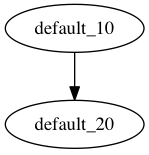

In [5]:
%preview -n test_dag.html
%rerun -p test_dag.html -d -s force